In [1]:
from Agents import *
from Vehicles import *
from Stations import *
import numpy as np
from chargingCosts import ChargingCosts
from matplotlib import pyplot as plt
np.random.seed(0)

In [2]:
def show_city(city):
    work = np.array([city.work() for _ in range(200)])
    home = np.array([city.home() for _ in range(1000)])
    stations = np.array([city.station() for _ in range(30)])
    plt.plot(work[:, 0], work[:, 1], "b.", label = "Work Locations")
    plt.plot(home[:, 0], home[:, 1], "y.", label = "Home Locations")
    plt.plot(stations[:, 0], stations[:, 1], "k.", label = "Charging Stations")
    plt.legend(loc=(1.04, .785))
    plt.xlim(0, city.city_size)
    plt.ylim(0, city.city_size)
    plt.show()

In [3]:
class DowntownModel:

    def __init__(self, city_size):
        self.city_size = city_size
    
    def home(self, is_uber = None):
        return np.random.normal(self.city_size * .5, self.city_size * .3, 2) % self.city_size

    def work(self, is_uber = None):
        return np.random.normal(self.city_size * .5, self.city_size * .12, 2) % self.city_size
    
    def station(self, is_uber = None):
        return np.random.uniform(0, self.city_size, 2)
    
    def shift_start(self, is_uber):
        if is_uber:
            return np.random.normal(10*60, 50)
        else:
            return np.random.normal(8*60, 45)
    
    def shift_end(self, shift_start, is_uber):
        if is_uber:
            return shift_start + np.random.normal(11*60, 50)
        else:
            return shift_start + np.random.normal(10*60, 45)

    def min_charge(self, is_uber = True):
        if is_uber:
            return np.random.normal(.35, .005)
        else:
            return np.random.normal(.15, .005)

    def uber(self):
        return np.random.random() < .1
    
    def get_vehicle(self, is_uber = None):
        return np.random.choice(["ModelS", "Mustang", "Ioniq", "Kia"], p = [.4, .1, .25, .25])
    
    def chargers_per_station(self, location = None):
        return np.random.randint(5, 30)
    
    def get_size(self):
        return self.city_size

#### Changes made to the files:
1. Uber Driver class now works in shift where they are more or less likely to choose one of the charging methods based on the behaviour we think they exhibit. Specifically, between 10 am and 3 pm, the UberDriver is assumed to be busy and thus picks Naive. Between 3 and 6 pm, the UberDriver is less busy and thus picks Scheduled. The next two shifts are more interesting. Between 6pm and 2 am, the Uber Driver can either be busy or not and thus picks naive/ shceduled based on a random roll. Similarly, for the remainder of the time, it's either naive or scheduled. We think this betters captures the dynamics of pickup/ drop behaviour due to UberDrivers wanting to capture more ride fees during late nights, which is either a busy night or a slow night. 

2. For the commuter on the other hand, we assumed a normally distributed leaving time in the morning and a departer from work time: 8 am and 6 pm respectively to capture peak time commute requirements to and fro work. The variance of this is 45 minutes. 

3. Further, the way the scheduled charging method works is as follows: the user can be plugged in for 7 hours and the function looks for the best charging windows in that time period i.e the time slots with lowest pricing and ensures the car only charges then. This results in cost saving behaviour. 

More realistically, this can be sold as a premium feature at charging stations. 


In [4]:
def run_simulation(POPULATION = 1000, NUM_STATIONS = 30, CITY = DowntownModel(100), NUM_DAYS = 1, PRINT = True):
    agents = []
    for i in range(POPULATION):
        if CITY.uber():
            #Uber driver agent
            id = i
            car = Vehicle(CITY.get_vehicle(True))
            home = CITY.home(True)
            shift_start = CITY.shift_start(True)
            shift_end = CITY.shift_end(shift_start, True)
            min_charge = CITY.min_charge(True)
            agents.append(UberDriver(id, car, home, shift_start, shift_end, CITY.get_size(), min_charge))
        else:
            #commuter agent
            id = i
            car = Vehicle(CITY.get_vehicle(False))
            home = CITY.home(False)
            work = CITY.work(False)
            min_charge = CITY.min_charge(False)
            shift_start = CITY.shift_start(False)
            shift_end = CITY.shift_end(shift_start, False)
            agents.append(Commuter(id, car, home, work, min_charge, shift_start, shift_end))

    stations = []
    prices = ChargingCosts()
    for i in range(NUM_STATIONS):
        id = i
        location = CITY.station()
        num_chargers = CITY.chargers_per_station(location)
        price = prices.simulate(NUM_DAYS + 1).flatten()
        stations.append(ChargingStation(station_id = i, 
                                        num_chargers = num_chargers, 
                                        location = location, 
                                        price = price))
    
    if PRINT:
        print("Starting simulation")

    for time in range(NUM_DAYS * 24 * 60):
        for agent in agents:
            agent.update_location()
            agent.update_busy()
            agent.log(time)
            if agent.is_busy(time):
                continue
            agent_action = agent.get_action(time)
            if agent_action == "drive":
                destination = agent.drive_location(time)
                agent.drive(destination, time)
            if agent_action == "charge":
                station = agent.charge_location(stations)
                agent.drive(station.location, time)
                station.enqueue_agent(agent, time)

                # Check if the station is available
                station_available = station.get_num_available(time) > 0
                if station_available:
                    station.enqueue_agent(agent, time)
                    agent.charge(station, time)
                else:
                    # Find the next closest station if the current station is not available
                    closest_station = None
                    min_distance = float("inf")
                    for s in stations:
                        if s ==  station:
                            continue
                        if s.get_num_available(time) > 0:
                            dist = np.linalg.norm(agent.get_location() - s.get_location())
                            if dist < min_distance:
                                min_distance = dist
                                closest_station = s

                    if closest_station is not None:
                        agent.drive(closest_station.get_location(), time)
                        closest_station.enqueue_agent(agent, time)
                        agent.charge(station, time)
        # Update charging agents at each station
        for station in stations:
            station.update_charging_agents(time)
            station.log(time)
    
    if PRINT:
        print("Finished simulation")
    return agents, stations

In [5]:
population = 1000
num_stations = 30
city_size = 100
city = DowntownModel(city_size)
num_days = 2
agents, stations = run_simulation(POPULATION=population, NUM_STATIONS=num_stations, CITY = city, NUM_DAYS = num_days)

Starting simulation
Finished simulation


In [7]:
total_naive_cost = 0
total_scheduled_cost = 0
total_distance = 0
total_energy = 0
for agent in agents:
    logs = agent.get_logs()
    last_log = logs[-1]
    total_naive_cost += last_log["naive_cost"]
    total_scheduled_cost += last_log["scheduled_cost"]
    total_distance += last_log["distance_driven"]
    total_energy += last_log["energy_used"]

print("Total naive cost:", total_naive_cost)
print("Total scheduled cost:", total_scheduled_cost)
print("Cost differential:", total_naive_cost - total_scheduled_cost)
print()
print("Total distance driven:", total_distance)
print("Total energy used:", total_energy)

Total naive cost: 624.398978070688
Total scheduled cost: 438.84082643897904
Cost differential: 185.558151631709

Total distance driven: 439074.35544851125
Total energy used: 6664.552297981489


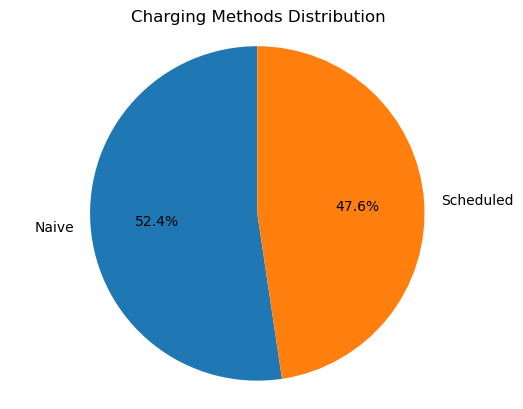

In [8]:
naive_count = 0
scheduled_count = 0

for agent in agents:
    for log in agent.get_logs():
        if log["charging_method"] == "naive":
            naive_count += 1
        elif log["charging_method"] == "scheduled":
            scheduled_count += 1

labels = ["Naive", "Scheduled"]
sizes = [naive_count, scheduled_count]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')

plt.title("Charging Methods Distribution")
plt.show()

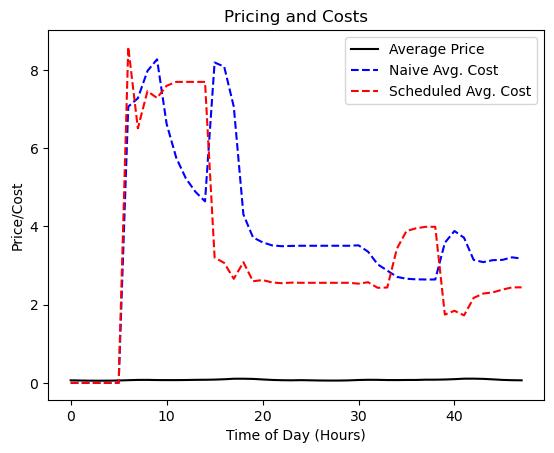

In [9]:
hours = list(range(num_days * 24))
avg_prices = [sum([station.get_price(i * 60) for station in stations]) / len(stations) for i in hours]

naive_costs = [0] * num_days * 24
scheduled_costs = [0] * num_days * 24
naive_counts = [0] * num_days * 24
scheduled_counts = [0] * num_days * 24

for agent in agents:
    for log in agent.get_logs():
        hour = log["time"] // 60
        if log["charging_method"] == "naive":
            naive_costs[hour] += log["naive_cost"]
            naive_counts[hour] += 1
        elif log["charging_method"] == "scheduled":
            scheduled_costs[hour] += log["scheduled_cost"]
            scheduled_counts[hour] += 1

naive_avg_costs = [naive_costs[i] / naive_counts[i] if naive_counts[i] > 0 else 0 for i in hours]
scheduled_avg_costs = [scheduled_costs[i] / scheduled_counts[i] if scheduled_counts[i] > 0 else 0 for i in hours]

fig, ax = plt.subplots()
ax.plot(hours, avg_prices, label="Average Price", color="black")
ax.plot(hours, naive_avg_costs, label="Naive Avg. Cost", linestyle="--", color="blue")
ax.plot(hours, scheduled_avg_costs, label="Scheduled Avg. Cost", linestyle="--", color="red")
ax.legend()
plt.title("Pricing and Costs")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Price/Cost")
plt.show()

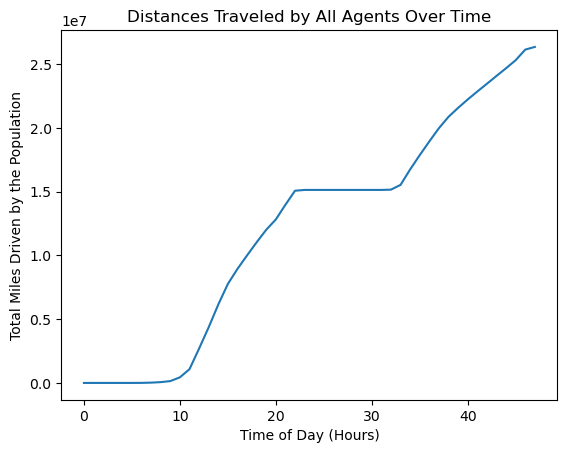

In [10]:
hours = list(range(num_days * 24))
distances = np.zeros(num_days * 24)
for agent in agents:
    for log in agent.get_logs():
        hour = log["time"] // 60
        distances[hour] += log["distance_driven"]
plt.plot(hours, distances)
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Total Miles Driven by the Population")
plt.title("Distances Traveled by All Agents Over Time")
plt.show()

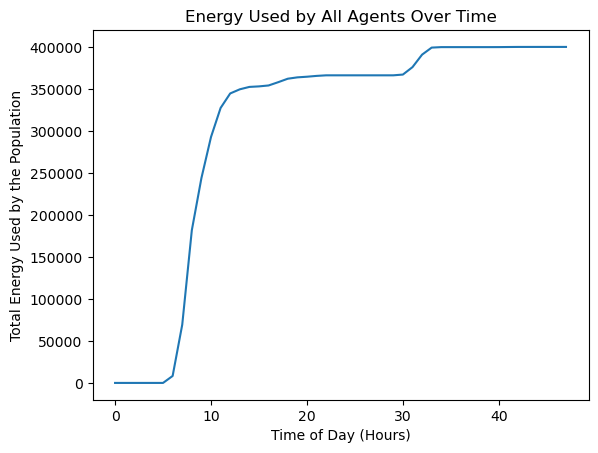

In [11]:
hours = list(range(num_days * 24))
distances = np.zeros(num_days * 24)
for agent in agents:
    for log in agent.get_logs():
        hour = log["time"] // 60
        distances[hour] += log["energy_used"]
plt.plot(hours, distances)
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Total Energy Used by the Population")
plt.title("Energy Used by All Agents Over Time")
plt.show()

In [15]:
import time

population = 1000
num_stations = 30
city_size = 100
num_days = 2
city = DowntownModel(city_size)

# M: Number of simulations to run to estimate the naive and scheduled charging
# costs with Monte Carlo
M = 300

total_Uber_naive_cost = np.zeros(M,)
total_Uber_scheduled_cost = np.zeros(M,)
total_Uber_distance = np.zeros(M,)
total_Uber_energy = np.zeros(M,)
total_Uber_naive_energy_charged = np.zeros(M,)
total_Uber_scheduled_energy_charged = np.zeros(M,)
total_Uber_naive_time_plugged_in = np.zeros(M,)
total_Uber_scheduled_time_plugged_in = np.zeros(M,)

total_Commuter_naive_cost = np.zeros(M,)
total_Commuter_scheduled_cost = np.zeros(M,)
total_Commuter_distance = np.zeros(M,)
total_Commuter_energy = np.zeros(M,)
total_Commuter_naive_energy_charged = np.zeros(M,)
total_Commuter_scheduled_energy_charged = np.zeros(M,)
total_Commuter_naive_time_plugged_in = np.zeros(M,)
total_Commuter_scheduled_time_plugged_in = np.zeros(M,)

num_ubers = np.zeros(M,)
num_commuters = np.zeros(M,)
    
print("Simulations started")
start_time = time.time()
for i in range(M):
    if isinstance(i/10, int):
        print(i, "simulations finished")
        
    agents, stations = run_simulation(POPULATION=population, NUM_STATIONS=num_stations, CITY = city, NUM_DAYS = num_days, PRINT = False)
    for agent in agents:
        logs = agent.get_logs()
        last_log = logs[-1]
        if isinstance(agent, Commuter):
            total_Commuter_naive_cost[i] += last_log["naive_cost"]
            total_Commuter_scheduled_cost[i] += last_log["scheduled_cost"]
            total_Commuter_naive_energy_charged[i] += last_log["naive_charged_energy"]
            total_Commuter_scheduled_energy_charged[i] += last_log["scheduled_charged_energy"]
            total_Commuter_naive_time_plugged_in[i] += last_log["naive_charged_time"]
            total_Commuter_scheduled_time_plugged_in[i] += last_log["scheduled_charged_time"]
            total_Commuter_distance[i] += last_log["distance_driven"]
            total_Commuter_energy[i] += last_log["energy_used"]
            num_commuters[i] += 1
        else:
            total_Uber_naive_cost[i] += last_log["naive_cost"]
            total_Uber_scheduled_cost[i] += last_log["scheduled_cost"]
            total_Uber_naive_energy_charged[i] += last_log["naive_charged_energy"]
            total_Uber_scheduled_energy_charged[i] += last_log["scheduled_charged_energy"]
            total_Uber_naive_time_plugged_in[i] += last_log["naive_charged_time"]
            total_Uber_scheduled_time_plugged_in[i] += last_log["scheduled_charged_time"]
            total_Uber_distance[i] += last_log["distance_driven"]
            total_Uber_energy[i] += last_log["energy_used"]
            num_ubers[i] += 1
            
print("Simulations finished")
print("Time of first run of simulations:", (time.time()-start_time)/60, "minutes")

# Save the values to a .csv file
data = {'num_ubers': num_ubers,
        'num_cummters': num_commuters,
        'total_Uber_naive_cost': total_Uber_naive_cost,
        'total_Uber_scheduled_cost': total_Uber_scheduled_cost,
        'total_Uber_distance': total_Uber_distance,
        'total_Uber_energy': total_Uber_energy,
        'total_Uber_naive_energy_charged': total_Uber_naive_energy_charged,
        'total_Uber_scheduled_energy_charged': total_Uber_scheduled_energy_charged,
        'total_Uber_naive_time_plugged_in': total_Uber_naive_time_plugged_in,
        'total_Uber_scheduled_time_plugged_in': total_Uber_scheduled_time_plugged_in,
        'total_Commuter_naive_cost': total_Commuter_naive_cost,
        'total_Commuter_scheduled_cost': total_Commuter_scheduled_cost,
        'total_Commuter_distance': total_Commuter_distance,
        'total_Commuter_energy': total_Commuter_energy,
        'total_Commuter_naive_energy_charged': total_Commuter_naive_energy_charged,
        'total_Commuter_scheduled_energy_charged': total_Commuter_scheduled_energy_charged,
        'total_Commuter_naive_time_plugged_in': total_Commuter_naive_time_plugged_in,
        'total_Commuter_scheduled_time_plugged_in': total_Commuter_scheduled_time_plugged_in}
     
np.savetxt('single_city_MC_data.csv', np.column_stack(data.values()), delimiter=',', header=','.join(data.keys()), comments='')





# We repeat the process but we create a new city for each simulation.

# M: Number of simulations to run to estimate the naive and scheduled charging
# costs with Monte Carlo
M = 300

total_Uber_naive_cost = np.zeros(M,)
total_Uber_scheduled_cost = np.zeros(M,)
total_Uber_distance = np.zeros(M,)
total_Uber_energy = np.zeros(M,)
total_Uber_naive_energy_charged = np.zeros(M,)
total_Uber_scheduled_energy_charged = np.zeros(M,)
total_Uber_naive_time_plugged_in = np.zeros(M,)
total_Uber_scheduled_time_plugged_in = np.zeros(M,)

total_Commuter_naive_cost = np.zeros(M,)
total_Commuter_scheduled_cost = np.zeros(M,)
total_Commuter_distance = np.zeros(M,)
total_Commuter_energy = np.zeros(M,)
total_Commuter_naive_energy_charged = np.zeros(M,)
total_Commuter_scheduled_energy_charged = np.zeros(M,)
total_Commuter_naive_time_plugged_in = np.zeros(M,)
total_Commuter_scheduled_time_plugged_in = np.zeros(M,)

num_ubers = np.zeros(M,)
num_commuters = np.zeros(M,)
    
start_time = time.time()
print("Simulations started")
for i in range(M):
    if isinstance(i/10, int):
        print(i, "simulations finished")
        
    city = DowntownModel(city_size)
    agents, stations = run_simulation(POPULATION=population, NUM_STATIONS=num_stations, CITY = city, NUM_DAYS = num_days, PRINT = False)
    for agent in agents:
        logs = agent.get_logs()
        last_log = logs[-1]
        if isinstance(agent, Commuter):
            total_Commuter_naive_cost[i] += last_log["naive_cost"]
            total_Commuter_scheduled_cost[i] += last_log["scheduled_cost"]
            total_Commuter_naive_energy_charged[i] += last_log["naive_charged_energy"]
            total_Commuter_scheduled_energy_charged[i] += last_log["scheduled_charged_energy"]
            total_Commuter_naive_time_plugged_in[i] += last_log["naive_charged_time"]
            total_Commuter_scheduled_time_plugged_in[i] += last_log["scheduled_charged_time"]
            total_Commuter_distance[i] += last_log["distance_driven"]
            total_Commuter_energy[i] += last_log["energy_used"]
            num_commuters[i] += 1
        else:
            total_Uber_naive_cost[i] += last_log["naive_cost"]
            total_Uber_scheduled_cost[i] += last_log["scheduled_cost"]
            total_Uber_naive_energy_charged[i] += last_log["naive_charged_energy"]
            total_Uber_scheduled_energy_charged[i] += last_log["scheduled_charged_energy"]
            total_Uber_naive_time_plugged_in[i] += last_log["naive_charged_time"]
            total_Uber_scheduled_time_plugged_in[i] += last_log["scheduled_charged_time"]
            total_Uber_distance[i] += last_log["distance_driven"]
            total_Uber_energy[i] += last_log["energy_used"]
            num_ubers[i] += 1
            
print("Simulations finished")
print("Time of second run of simulations:", (time.time()-start_time)/60, "minutes")

# Save the values to a .csv file
data = {'num_ubers': num_ubers,
        'num_cummters': num_commuters,
        'total_Uber_naive_cost': total_Uber_naive_cost,
        'total_Uber_scheduled_cost': total_Uber_scheduled_cost,
        'total_Uber_distance': total_Uber_distance,
        'total_Uber_energy': total_Uber_energy,
        'total_Uber_naive_energy_charged': total_Uber_naive_energy_charged,
        'total_Uber_scheduled_energy_charged': total_Uber_scheduled_energy_charged,
        'total_Uber_naive_time_plugged_in': total_Uber_naive_time_plugged_in,
        'total_Uber_scheduled_time_plugged_in': total_Uber_scheduled_time_plugged_in,
        'total_Commuter_naive_cost': total_Commuter_naive_cost,
        'total_Commuter_scheduled_cost': total_Commuter_scheduled_cost,
        'total_Commuter_distance': total_Commuter_distance,
        'total_Commuter_energy': total_Commuter_energy,
        'total_Commuter_naive_energy_charged': total_Commuter_naive_energy_charged,
        'total_Commuter_scheduled_energy_charged': total_Commuter_scheduled_energy_charged,
        'total_Commuter_naive_time_plugged_in': total_Commuter_naive_time_plugged_in,
        'total_Commuter_scheduled_time_plugged_in': total_Commuter_scheduled_time_plugged_in}
     
np.savetxt('multiple_cities_MC_data.csv', np.column_stack(data.values()), delimiter=',', header=','.join(data.keys()), comments='')
        

Simulations started
Simulations finished
Time of first run of simulations: 133.62847314675648 minutes
Simulations started


/var/folders/5d/8m3hzv7x7ds7tn6grh9kwywm0000gn/T/ipykernel_52960/1879202770.py:88: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  np.savetxt('single_city_MC_data.csv', np.column_stack(data.values()), delimiter=',', header=','.join(data.keys()), comments='')


Simulations finished
Time of second run of simulations: 135.3614782969157 minutes


/var/folders/5d/8m3hzv7x7ds7tn6grh9kwywm0000gn/T/ipykernel_52960/1879202770.py:176: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  np.savetxt('multiple_cities_MC_data.csv', np.column_stack(data.values()), delimiter=',', header=','.join(data.keys()), comments='')


In [8]:
class CloseSuburbs:

    def __init__(self, city_size):
        self.city_size = city_size
    
    def home(self, is_uber = None):
        return np.random.normal(self.city_size * .5, self.city_size * .3, 2) % self.city_size

    def work(self, is_uber = None):
        return np.random.normal(self.city_size * .5, self.city_size * .12, 2) % self.city_size
    
    def station(self, is_uber = None):
        return np.random.uniform(0, self.city_size, 2)
    
    def shift_start(self, is_uber):
        if is_uber:
            return np.random.normal(10*60, 50)
        else:
            return np.random.normal(8*60, 45)
    
    def shift_end(self, shift_start, is_uber):
        if is_uber:
            return shift_start + np.random.normal(8*60, 75)  # Shorter shifts for Uber drivers in CloseSuburbs
        else:
            return shift_start + np.random.normal(10*60, 45)

    def min_charge(self, is_uber = True):
        if is_uber:
            return np.random.normal(.4, .05)
        else:
            return np.random.normal(.15, .005)

    def uber(self):
        return np.random.random() < .1
    
    def get_vehicle(self, is_uber = None):
        return np.random.choice(["ModelS", "Mustang", "Ioniq", "Kia"], p = [.6, .05, .15, .20])
    
    def chargers_per_station(self, location = None):
        return np.random.randint(5, 20)
    
    def get_size(self):
        return self.city_size

In [11]:
def run_simulation(POPULATION = 1000, NUM_STATIONS = 30, CITY = CloseSuburbs(100), NUM_DAYS = 1):
    agents = []
    for i in range(POPULATION):
        if CITY.uber():
            #Uber driver agent
            id = i
            car = Vehicle(CITY.get_vehicle(True))
            home = CITY.home(True)
            shift_start = CITY.shift_start(True)
            shift_end = CITY.shift_end(shift_start, True)
            min_charge = CITY.min_charge(True)
            agents.append(UberDriver(id, car, home, shift_start, shift_end, CITY.get_size(), min_charge))
        else:
            #commuter agent
            id = i
            car = Vehicle(CITY.get_vehicle(False))
            home = CITY.home(False)
            work = CITY.work(False)
            min_charge = CITY.min_charge(False)
            shift_start = CITY.shift_start(False)
            shift_end = CITY.shift_end(shift_start, False)
            agents.append(Commuter(id, car, home, work, min_charge, shift_start, shift_end))

    stations = []
    prices = ChargingCosts()
    for i in range(NUM_STATIONS):
        id = i
        location = CITY.station()
        num_chargers = CITY.chargers_per_station(location)
        price = prices.simulate(NUM_DAYS + 1).flatten()
        stations.append(ChargingStation(station_id = i, 
                                        num_chargers = num_chargers, 
                                        location = location, 
                                        price = price))

    print("Starting simulation")

    for time in range(NUM_DAYS * 24 * 60):
        for agent in agents:
            agent.update_location()
            agent.update_busy()
            agent.log(time)
            if agent.is_busy(time):
                continue
            agent_action = agent.get_action(time)
            if agent_action == "drive":
                destination = agent.drive_location(time)
                agent.drive(destination, time)
            if agent_action == "charge":
                station = agent.charge_location(stations)
                agent.drive(station.location, time)
                station.enqueue_agent(agent, time)

                # Check if the station is available
                station_available = station.get_num_available(time) > 0
                if station_available:
                    station.enqueue_agent(agent, time)
                    agent.charge(station, time)
                else:
                    # Find the next closest station if the current station is not available
                    closest_station = None
                    min_distance = float("inf")
                    for s in stations:
                        if s ==  station:
                            continue
                        if s.get_num_available(time) > 0:
                            dist = np.linalg.norm(agent.get_location() - s.get_location())
                            if dist < min_distance:
                                min_distance = dist
                                closest_station = s

                    if closest_station is not None:
                        agent.drive(closest_station.get_location(), time)
                        closest_station.enqueue_agent(agent, time)
                        agent.charge(station, time)
        # Update charging agents at each station
        for station in stations:
            station.update_charging_agents(time)
            station.log(time)

    print("Finished simulation")
    return agents, stations

In [12]:
population = 600
num_stations = 15
city_size = 100
city = CloseSuburbs(city_size)
num_days = 2
agents, stations = run_simulation(POPULATION=population, NUM_STATIONS=num_stations, CITY = city, NUM_DAYS = num_days)

Starting simulation
Finished simulation


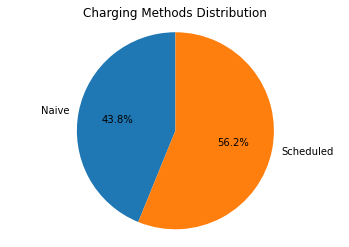

In [13]:
naive_count = 0
scheduled_count = 0

for agent in agents:
    for log in agent.get_logs():
        if log["charging_method"] == "naive":
            naive_count += 1
        elif log["charging_method"] == "scheduled":
            scheduled_count += 1

labels = ["Naive", "Scheduled"]
sizes = [naive_count, scheduled_count]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')

plt.title("Charging Methods Distribution")
plt.show()

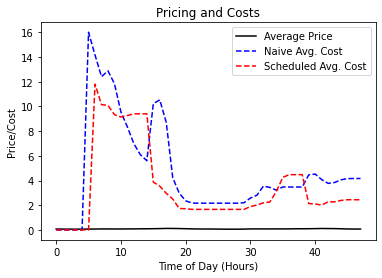

In [14]:
hours = list(range(num_days * 24))
avg_prices = [sum([station.get_price(i * 60) for station in stations]) / len(stations) for i in hours]

naive_costs = [0] * num_days * 24
scheduled_costs = [0] * num_days * 24
naive_counts = [0] * num_days * 24
scheduled_counts = [0] * num_days * 24

for agent in agents:
    for log in agent.get_logs():
        hour = log["time"] // 60
        if log["charging_method"] == "naive":
            naive_costs[hour] += log["naive_cost"]
            naive_counts[hour] += 1
        elif log["charging_method"] == "scheduled":
            scheduled_costs[hour] += log["scheduled_cost"]
            scheduled_counts[hour] += 1

naive_avg_costs = [naive_costs[i] / naive_counts[i] if naive_counts[i] > 0 else 0 for i in hours]
scheduled_avg_costs = [scheduled_costs[i] / scheduled_counts[i] if scheduled_counts[i] > 0 else 0 for i in hours]

fig, ax = plt.subplots()
ax.plot(hours, avg_prices, label="Average Price", color="black")
ax.plot(hours, naive_avg_costs, label="Naive Avg. Cost", linestyle="--", color="blue")
ax.plot(hours, scheduled_avg_costs, label="Scheduled Avg. Cost", linestyle="--", color="red")
ax.legend()
plt.title("Pricing and Costs")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Price/Cost")
plt.show()

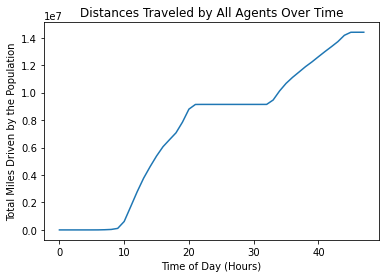

In [15]:
hours = list(range(num_days * 24))
distances = np.zeros(num_days * 24)
for agent in agents:
    for log in agent.get_logs():
        hour = log["time"] // 60
        distances[hour] += log["distance_driven"]
plt.plot(hours, distances)
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Total Miles Driven by the Population")
plt.title("Distances Traveled by All Agents Over Time")
plt.show()

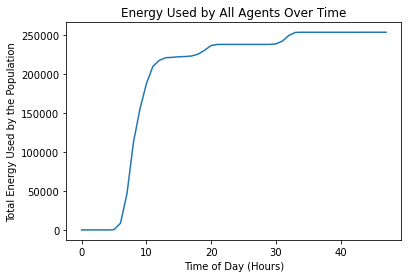

In [16]:
hours = list(range(num_days * 24))
distances = np.zeros(num_days * 24)
for agent in agents:
    for log in agent.get_logs():
        hour = log["time"] // 60
        distances[hour] += log["energy_used"]
plt.plot(hours, distances)
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Total Energy Used by the Population")
plt.title("Energy Used by All Agents Over Time")
plt.show()

In [7]:

class FarSuburbs:

    def __init__(self, city_size):
        self.city_size = city_size
    
    def home(self, is_uber = None):
        return np.random.normal(self.city_size * .5, self.city_size * .3, 2) % self.city_size

    def work(self, is_uber = None):
        return np.random.normal(self.city_size * .5, self.city_size * .12, 2) % self.city_size
    
    def station(self, is_uber = None):
        # Reduced number of stations in FarSuburbs
        return np.random.uniform(0, self.city_size, 2) * (np.random.random() < 0.5)
    
    def shift_start(self, is_uber):
        if is_uber:
            return np.random.normal(9*60, 120 )
        else:
            return np.random.normal(8*60, 60)
    
    def shift_end(self, shift_start, is_uber):
        if is_uber:
            return shift_start + np.random.normal(6*60, 90)  # Shorter shifts with higher variance for Uber drivers in FarSuburbs
        else:
            return shift_start + np.random.normal(10*60, 45)

    def min_charge(self, is_uber = True):
        if is_uber:
            return np.random.normal(.45, .01)
        else:
            return np.random.normal(.25, .005)

    def uber(self):
        return np.random.random() < .3
    
    def get_vehicle(self, is_uber = None):
        return np.random.choice(["ModelS", "Mustang", "Ioniq", "Kia"], p = [.1, .1, .3, .5])
    
    def chargers_per_station(self, location = None):
        return np.random.randint(4, 17)
    
    def get_size(self):
        return self.city_size

In [18]:
def run_simulation(POPULATION = 1000, NUM_STATIONS = 30, CITY = FarSuburbs(200), NUM_DAYS = 1):
    agents = []
    for i in range(POPULATION):
        if CITY.uber():
            #Uber driver agent
            id = i
            car = Vehicle(CITY.get_vehicle(True))
            home = CITY.home(True)
            shift_start = CITY.shift_start(True)
            shift_end = CITY.shift_end(shift_start, True)
            min_charge = CITY.min_charge(True)
            agents.append(UberDriver(id, car, home, shift_start, shift_end, CITY.get_size(), min_charge))
        else:
            #commuter agent
            id = i
            car = Vehicle(CITY.get_vehicle(False))
            home = CITY.home(False)
            work = CITY.work(False)
            min_charge = CITY.min_charge(False)
            shift_start = CITY.shift_start(False)
            shift_end = CITY.shift_end(shift_start, False)
            agents.append(Commuter(id, car, home, work, min_charge, shift_start, shift_end))

    stations = []
    prices = ChargingCosts()
    for i in range(NUM_STATIONS):
        id = i
        location = CITY.station()
        num_chargers = CITY.chargers_per_station(location)
        price = prices.simulate(NUM_DAYS + 1).flatten()
        stations.append(ChargingStation(station_id = i, 
                                        num_chargers = num_chargers, 
                                        location = location, 
                                        price = price))

    print("Starting simulation")

    for time in range(NUM_DAYS * 24 * 60):
        for agent in agents:
            agent.update_location()
            agent.update_busy()
            agent.log(time)
            if agent.is_busy(time):
                continue
            agent_action = agent.get_action(time)
            if agent_action == "drive":
                destination = agent.drive_location(time)
                agent.drive(destination, time)
            if agent_action == "charge":
                station = agent.charge_location(stations)
                agent.drive(station.location, time)
                station.enqueue_agent(agent, time)

                # Check if the station is available
                station_available = station.get_num_available(time) > 0
                if station_available:
                    station.enqueue_agent(agent, time)
                    agent.charge(station, time)
                else:
                    # Find the next closest station if the current station is not available
                    closest_station = None
                    min_distance = float("inf")
                    for s in stations:
                        if s ==  station:
                            continue
                        if s.get_num_available(time) > 0:
                            dist = np.linalg.norm(agent.get_location() - s.get_location())
                            if dist < min_distance:
                                min_distance = dist
                                closest_station = s

                    if closest_station is not None:
                        agent.drive(closest_station.get_location(), time)
                        closest_station.enqueue_agent(agent, time)
                        agent.charge(station, time)
        # Update charging agents at each station
        for station in stations:
            station.update_charging_agents(time)
            station.log(time)

    print("Finished simulation")
    return agents, stations

In [19]:
population = 700
num_stations = 20
city_size = 350
city = CloseSuburbs(city_size)
num_days = 2
agents, stations = run_simulation(POPULATION=population, NUM_STATIONS=num_stations, CITY = city, NUM_DAYS = num_days)

Starting simulation
Finished simulation


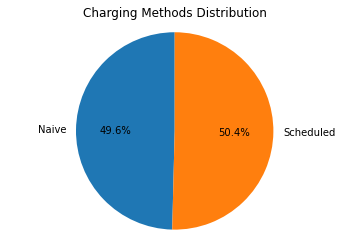

In [20]:
naive_count = 0
scheduled_count = 0

for agent in agents:
    for log in agent.get_logs():
        if log["charging_method"] == "naive":
            naive_count += 1
        elif log["charging_method"] == "scheduled":
            scheduled_count += 1

labels = ["Naive", "Scheduled"]
sizes = [naive_count, scheduled_count]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')

plt.title("Charging Methods Distribution")
plt.show()

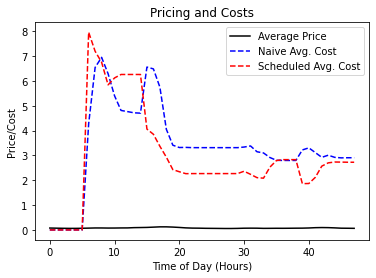

In [21]:
hours = list(range(num_days * 24))
avg_prices = [sum([station.get_price(i * 60) for station in stations]) / len(stations) for i in hours]

naive_costs = [0] * num_days * 24
scheduled_costs = [0] * num_days * 24
naive_counts = [0] * num_days * 24
scheduled_counts = [0] * num_days * 24

for agent in agents:
    for log in agent.get_logs():
        hour = log["time"] // 60
        if log["charging_method"] == "naive":
            naive_costs[hour] += log["naive_cost"]
            naive_counts[hour] += 1
        elif log["charging_method"] == "scheduled":
            scheduled_costs[hour] += log["scheduled_cost"]
            scheduled_counts[hour] += 1

naive_avg_costs = [naive_costs[i] / naive_counts[i] if naive_counts[i] > 0 else 0 for i in hours]
scheduled_avg_costs = [scheduled_costs[i] / scheduled_counts[i] if scheduled_counts[i] > 0 else 0 for i in hours]

fig, ax = plt.subplots()
ax.plot(hours, avg_prices, label="Average Price", color="black")
ax.plot(hours, naive_avg_costs, label="Naive Avg. Cost", linestyle="--", color="blue")
ax.plot(hours, scheduled_avg_costs, label="Scheduled Avg. Cost", linestyle="--", color="red")
ax.legend()
plt.title("Pricing and Costs")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Price/Cost")
plt.show()

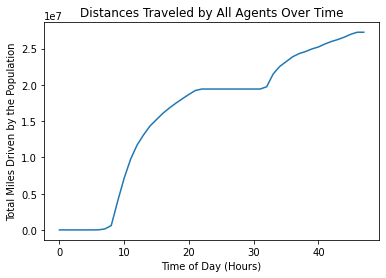

In [22]:
hours = list(range(num_days * 24))
distances = np.zeros(num_days * 24)
for agent in agents:
    for log in agent.get_logs():
        hour = log["time"] // 60
        distances[hour] += log["distance_driven"]
plt.plot(hours, distances)
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Total Miles Driven by the Population")
plt.title("Distances Traveled by All Agents Over Time")
plt.show()

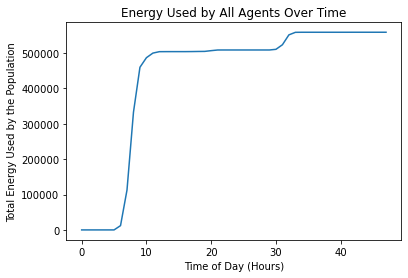

In [23]:
hours = list(range(num_days * 24))
distances = np.zeros(num_days * 24)
for agent in agents:
    for log in agent.get_logs():
        hour = log["time"] // 60
        distances[hour] += log["energy_used"]
plt.plot(hours, distances)
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Total Energy Used by the Population")
plt.title("Energy Used by All Agents Over Time")
plt.show()